# Task 3: Fake News Detection (Binary Classification)

## Overview
This notebook implements a comprehensive fake news detection system using machine learning approaches. We'll build a binary classifier to distinguish between real and fake news articles using the **Fake and Real News Dataset**.

## Learning Objectives
- Apply text preprocessing techniques for fake news detection
- Implement advanced feature extraction using TF-IDF and Count Vectorization
- Build and compare multiple binary classification models
- Analyze linguistic patterns distinguishing fake from real news
- Create word cloud visualizations and feature analysis
- Understand the challenges and ethics of automated fact-checking

## Dataset
We'll use the Fake and Real News Dataset with:
- **Fake.csv**: Collection of fake news articles 
- **True.csv**: Collection of real news articles
- **Features**: title, text, subject, date

## Pipeline Overview
1. **Data Loading & Exploration**
2. **Text Preprocessing** (cleaning, tokenization, normalization)
3. **Exploratory Data Analysis** (linguistic patterns, word clouds)
4. **Feature Extraction** (TF-IDF, Count Vectorization, N-grams)
5. **Model Training** (Logistic Regression, SVM, Random Forest, Naive Bayes)
6. **Model Evaluation & Comparison**
7. **Feature Analysis** (most indicative words for fake vs real news)
8. **Real-world Testing** (prediction system)


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from collections import Counter
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# Try to import spaCy for advanced text analysis
try:
    import spacy
    # Try to load English model
    try:
        nlp = spacy.load("en_core_web_sm")
        SPACY_AVAILABLE = True
        print("spaCy with en_core_web_sm model loaded successfully!")
    except OSError:
        SPACY_AVAILABLE = False
        print("spaCy model 'en_core_web_sm' not found. Install with: python -m spacy download en_core_web_sm")
except ImportError:
    SPACY_AVAILABLE = False
    print("spaCy not available. Install with: pip install spacy")

# Import our custom utilities
import sys
sys.path.append('./utils')
from preprocessing import TextPreprocessor
from evaluation import evaluate_classification, plot_roc_curve, compare_models

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")


spaCy with en_core_web_sm model loaded successfully!
Libraries imported successfully!


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\assem\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1. Data Loading and Exploration

We'll load the Fake and Real News datasets and explore their structure and characteristics.


In [2]:
# Load the Fake and Real News datasets
print("Loading Fake and Real News Dataset...")

# Load fake news data
fake_df = pd.read_csv('../Fake and Real News Dataset/Fake.csv')
fake_df['label'] = 0  # 0 for fake news

# Load real news data
real_df = pd.read_csv('../Fake and Real News Dataset/True.csv')
real_df['label'] = 1  # 1 for real news

print("✅ Successfully loaded Fake and Real News datasets!")

# Combine datasets
df = pd.concat([fake_df, real_df], ignore_index=True)

# Create combined text from title and text
df['full_text'] = df['title'].astype(str) + ' ' + df['text'].astype(str)

# Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Combined dataset shape: {df.shape}")
print(f"Fake news articles: {len(fake_df)}")
print(f"Real news articles: {len(real_df)}")
print(f"Columns: {df.columns.tolist()}")

print("\nFirst few rows:")
print(df[['title', 'subject', 'label']].head())

print(f"\nLabel distribution:")
label_counts = df['label'].value_counts()
print(f"Fake (0): {label_counts[0]} ({label_counts[0]/len(df)*100:.1f}%)")
print(f"Real (1): {label_counts[1]} ({label_counts[1]/len(df)*100:.1f}%)")

print(f"\nSubject distribution:")
print(df['subject'].value_counts())


Loading Fake and Real News Dataset...
✅ Successfully loaded Fake and Real News datasets!
Combined dataset shape: (44898, 6)
Fake news articles: 23481
Real news articles: 21417
Columns: ['title', 'text', 'subject', 'date', 'label', 'full_text']

First few rows:
                                               title       subject  label
0  Ben Stein Calls Out 9th Circuit Court: Committ...       US_News      0
1  Trump drops Steve Bannon from National Securit...  politicsNews      1
2  Puerto Rico expects U.S. to lift Jones Act shi...  politicsNews      1
3   OOPS: Trump Just Accidentally Confirmed He Le...          News      0
4  Donald Trump heads for Scotland to reopen a go...  politicsNews      1

Label distribution:
Fake (0): 23481 (52.3%)
Real (1): 21417 (47.7%)

Subject distribution:
subject
politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east         

In [3]:
# Basic text statistics and exploration
print("Basic text statistics:")
df['text_length'] = df['full_text'].str.len()
df['word_count'] = df['full_text'].str.split().str.len()
df['title_length'] = df['title'].str.len()

print(f"Average full text length: {df['text_length'].mean():.2f} characters")
print(f"Average word count: {df['word_count'].mean():.2f} words")
print(f"Average title length: {df['title_length'].mean():.2f} characters")

# Compare fake vs real news statistics
print("\n" + "="*80)
print("FAKE vs REAL NEWS COMPARISON")
print("="*80)

fake_stats = df[df['label'] == 0]
real_stats = df[df['label'] == 1]

print(f"\nFAKE NEWS:")
print(f"  Average text length: {fake_stats['text_length'].mean():.2f} characters")
print(f"  Average word count: {fake_stats['word_count'].mean():.2f} words")
print(f"  Average title length: {fake_stats['title_length'].mean():.2f} characters")

print(f"\nREAL NEWS:")
print(f"  Average text length: {real_stats['text_length'].mean():.2f} characters")
print(f"  Average word count: {real_stats['word_count'].mean():.2f} words")
print(f"  Average title length: {real_stats['title_length'].mean():.2f} characters")

# Show sample articles
print("\n" + "="*80)
print("SAMPLE ARTICLES")
print("="*80)

print(f"\nSAMPLE FAKE NEWS:")
fake_sample = df[df['label'] == 0].iloc[0]
print(f"Title: {fake_sample['title']}")
print(f"Subject: {fake_sample['subject']}")
print(f"Text: {fake_sample['text'][:300]}...")

print(f"\nSAMPLE REAL NEWS:")
real_sample = df[df['label'] == 1].iloc[0]
print(f"Title: {real_sample['title']}")
print(f"Subject: {real_sample['subject']}")
print(f"Text: {real_sample['text'][:300]}...")


Basic text statistics:
Average full text length: 2550.22 characters
Average word count: 417.74 words
Average title length: 80.11 characters

FAKE vs REAL NEWS COMPARISON

FAKE NEWS:
  Average text length: 2642.59 characters
  Average word count: 437.93 words
  Average title length: 94.20 characters

REAL NEWS:
  Average text length: 2448.95 characters
  Average word count: 395.59 words
  Average title length: 64.67 characters

SAMPLE ARTICLES

SAMPLE FAKE NEWS:
Title: Ben Stein Calls Out 9th Circuit Court: Committed a ‘Coup d’état’ Against the Constitution
Subject: US_News
Text: 21st Century Wire says Ben Stein, reputable professor from, Pepperdine University (also of some Hollywood fame appearing in TV shows and films such as Ferris Bueller s Day Off) made some provocative statements on Judge Jeanine Pirro s show recently. While discussing the halt that was imposed on Pres...

SAMPLE REAL NEWS:
Title: Trump drops Steve Bannon from National Security Council
Subject: politicsNews
Text: 

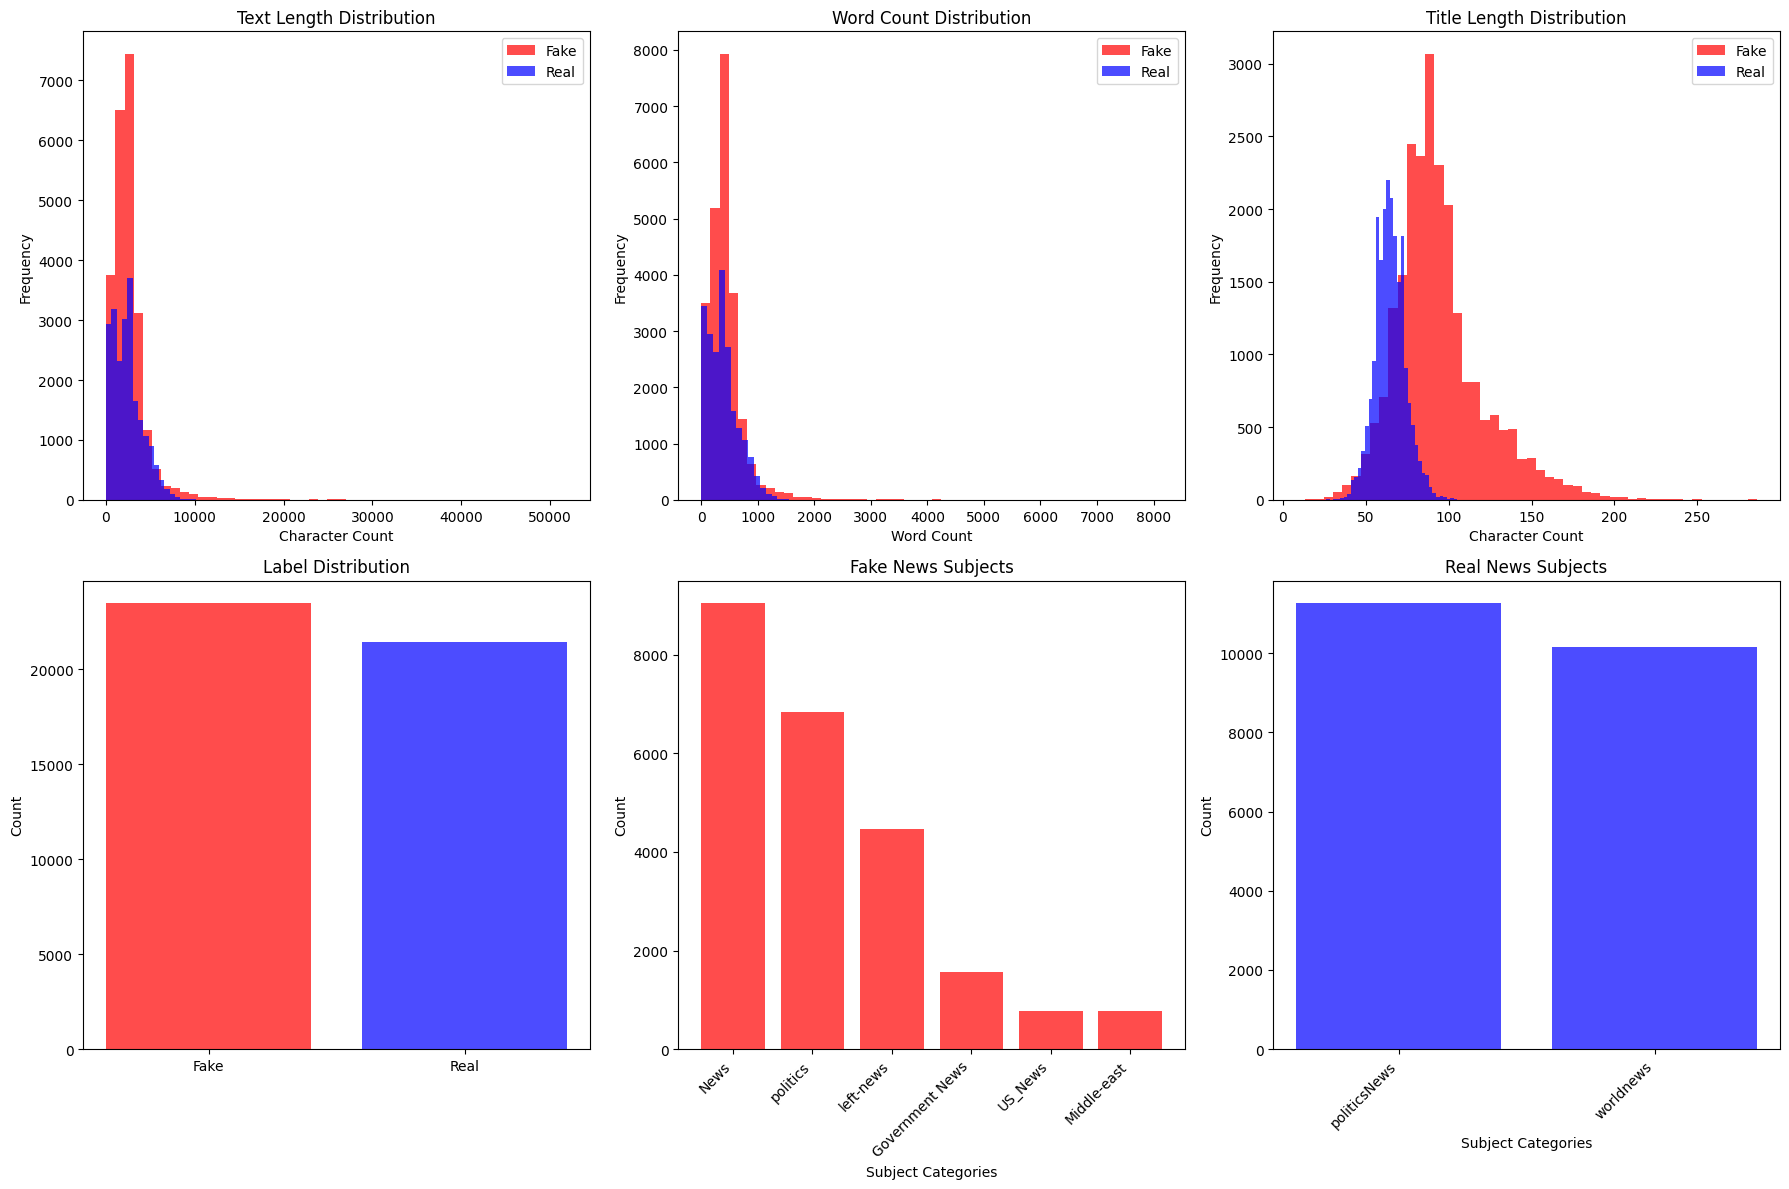


Key Observations:
- Dataset is imbalanced
- Fake news avg length: 2643 chars
- Real news avg length: 2449 chars
- Length difference: 194 chars


In [4]:
# Visualize data distribution and patterns
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Text length distribution
axes[0, 0].hist(fake_stats['text_length'], bins=50, alpha=0.7, color='red', label='Fake')
axes[0, 0].hist(real_stats['text_length'], bins=50, alpha=0.7, color='blue', label='Real')
axes[0, 0].set_title('Text Length Distribution')
axes[0, 0].set_xlabel('Character Count')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()

# Word count distribution
axes[0, 1].hist(fake_stats['word_count'], bins=50, alpha=0.7, color='red', label='Fake')
axes[0, 1].hist(real_stats['word_count'], bins=50, alpha=0.7, color='blue', label='Real')
axes[0, 1].set_title('Word Count Distribution')
axes[0, 1].set_xlabel('Word Count')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

# Title length distribution
axes[0, 2].hist(fake_stats['title_length'], bins=50, alpha=0.7, color='red', label='Fake')
axes[0, 2].hist(real_stats['title_length'], bins=50, alpha=0.7, color='blue', label='Real')
axes[0, 2].set_title('Title Length Distribution')
axes[0, 2].set_xlabel('Character Count')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].legend()

# Label distribution
label_counts = df['label'].value_counts()
axes[1, 0].bar(['Fake', 'Real'], label_counts.values, color=['red', 'blue'], alpha=0.7)
axes[1, 0].set_title('Label Distribution')
axes[1, 0].set_ylabel('Count')

# Subject distribution for fake news
fake_subjects = fake_stats['subject'].value_counts().head(8)
axes[1, 1].bar(range(len(fake_subjects)), fake_subjects.values, color='red', alpha=0.7)
axes[1, 1].set_title('Fake News Subjects')
axes[1, 1].set_xlabel('Subject Categories')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_xticks(range(len(fake_subjects)))
axes[1, 1].set_xticklabels(fake_subjects.index, rotation=45, ha='right')

# Subject distribution for real news
real_subjects = real_stats['subject'].value_counts().head(8)
axes[1, 2].bar(range(len(real_subjects)), real_subjects.values, color='blue', alpha=0.7)
axes[1, 2].set_title('Real News Subjects')
axes[1, 2].set_xlabel('Subject Categories')
axes[1, 2].set_ylabel('Count')
axes[1, 2].set_xticks(range(len(real_subjects)))
axes[1, 2].set_xticklabels(real_subjects.index, rotation=45, ha='right')

plt.tight_layout()
plt.show()

print(f"\nKey Observations:")
print(f"- Dataset is {'balanced' if abs(label_counts[0] - label_counts[1]) < 1000 else 'imbalanced'}")
print(f"- Fake news avg length: {fake_stats['text_length'].mean():.0f} chars")
print(f"- Real news avg length: {real_stats['text_length'].mean():.0f} chars")
print(f"- Length difference: {abs(fake_stats['text_length'].mean() - real_stats['text_length'].mean()):.0f} chars")


## 2. Text Preprocessing

We'll apply comprehensive text preprocessing specifically designed for fake news detection.


In [5]:
# Initialize text preprocessor for fake news detection
preprocessor = TextPreprocessor(
    remove_html=True,
    expand_contractions=True,
    to_lowercase=True,
    remove_punctuation=True,
    remove_numbers=False,  # Keep numbers as they might be important for fact-checking
    remove_stopwords=True,
    lemmatize=True,
    min_length=2
)

print("Original text example (FAKE NEWS):")
original_fake = fake_sample['full_text']
print(f"'{original_fake[:400]}...'")

# Apply preprocessing to a sample
processed_fake = preprocessor.preprocess_text(original_fake)
print("\nProcessed text example (FAKE NEWS):")
print(f"'{processed_fake[:400]}...'")

print(f"\nOriginal text example (REAL NEWS):")
original_real = real_sample['full_text']
print(f"'{original_real[:400]}...'")

processed_real = preprocessor.preprocess_text(original_real)
print("\nProcessed text example (REAL NEWS):")
print(f"'{processed_real[:400]}...'")

print(f"\nText reduction comparison:")
print(f"Fake news: {len(original_fake)} -> {len(processed_fake)} characters ({((len(original_fake) - len(processed_fake))/len(original_fake)*100):.1f}% reduction)")
print(f"Real news: {len(original_real)} -> {len(processed_real)} characters ({((len(original_real) - len(processed_real))/len(original_real)*100):.1f}% reduction)")


Original text example (FAKE NEWS):
'Ben Stein Calls Out 9th Circuit Court: Committed a ‘Coup d’état’ Against the Constitution 21st Century Wire says Ben Stein, reputable professor from, Pepperdine University (also of some Hollywood fame appearing in TV shows and films such as Ferris Bueller s Day Off) made some provocative statements on Judge Jeanine Pirro s show recently. While discussing the halt that was imposed on President Trum...'

Processed text example (FAKE NEWS):
'ben stein call 9th circuit court committed coup état constitution 21st century wire say ben stein reputable professor pepperdine university also hollywood fame appearing tv show film ferris bueller day made provocative statement judge jeanine pirro show recently discussing halt imposed president trump executive order travel stein referred judgement 9th circuit court washington state coup tat execu...'

Original text example (REAL NEWS):
'Trump drops Steve Bannon from National Security Council WASHINGTON (Reuters) - 

In [6]:
# Apply preprocessing to the entire dataset
# For demonstration, let's work with a subset for faster processing
sample_size = 20000  # 10k fake + 10k real
print(f"Working with {sample_size} articles for faster processing...")

# Sample the dataset while maintaining balance
fake_sample_df = fake_df.sample(n=sample_size//2, random_state=42)
real_sample_df = real_df.sample(n=sample_size//2, random_state=42)

# Combine and shuffle
sample_df = pd.concat([fake_sample_df, real_sample_df], ignore_index=True)
sample_df['full_text'] = sample_df['title'].astype(str) + ' ' + sample_df['text'].astype(str)
sample_df = sample_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Sample dataset shape: {sample_df.shape}")
print(f"Label distribution: {sample_df['label'].value_counts()}")

print("\nApplying text preprocessing to the dataset...")
print("This may take a few minutes...")

# Apply preprocessing
sample_df['processed_text'] = sample_df['full_text'].apply(preprocessor.preprocess_text)

print("✅ Preprocessing completed!")

# Compare text lengths before and after preprocessing
print("\nText length comparison:")
original_lengths = sample_df['full_text'].str.len()
processed_lengths = sample_df['processed_text'].str.len()

print(f"Original - Mean: {original_lengths.mean():.1f}, Median: {original_lengths.median():.1f}")
print(f"Processed - Mean: {processed_lengths.mean():.1f}, Median: {processed_lengths.median():.1f}")
print(f"Overall reduction: {((original_lengths.mean() - processed_lengths.mean()) / original_lengths.mean() * 100):.1f}%")


Working with 20000 articles for faster processing...
Sample dataset shape: (20000, 6)
Label distribution: label
1    10000
0    10000
Name: count, dtype: int64

Applying text preprocessing to the dataset...
This may take a few minutes...
✅ Preprocessing completed!

Text length comparison:
Original - Mean: 2543.7, Median: 2265.0
Processed - Mean: 1772.4, Median: 1567.5
Overall reduction: 30.3%


## 3. Exploratory Data Analysis - Word Clouds

Let's create word clouds to visualize the most common terms in fake vs real news.


Creating word clouds for Fake vs Real News...


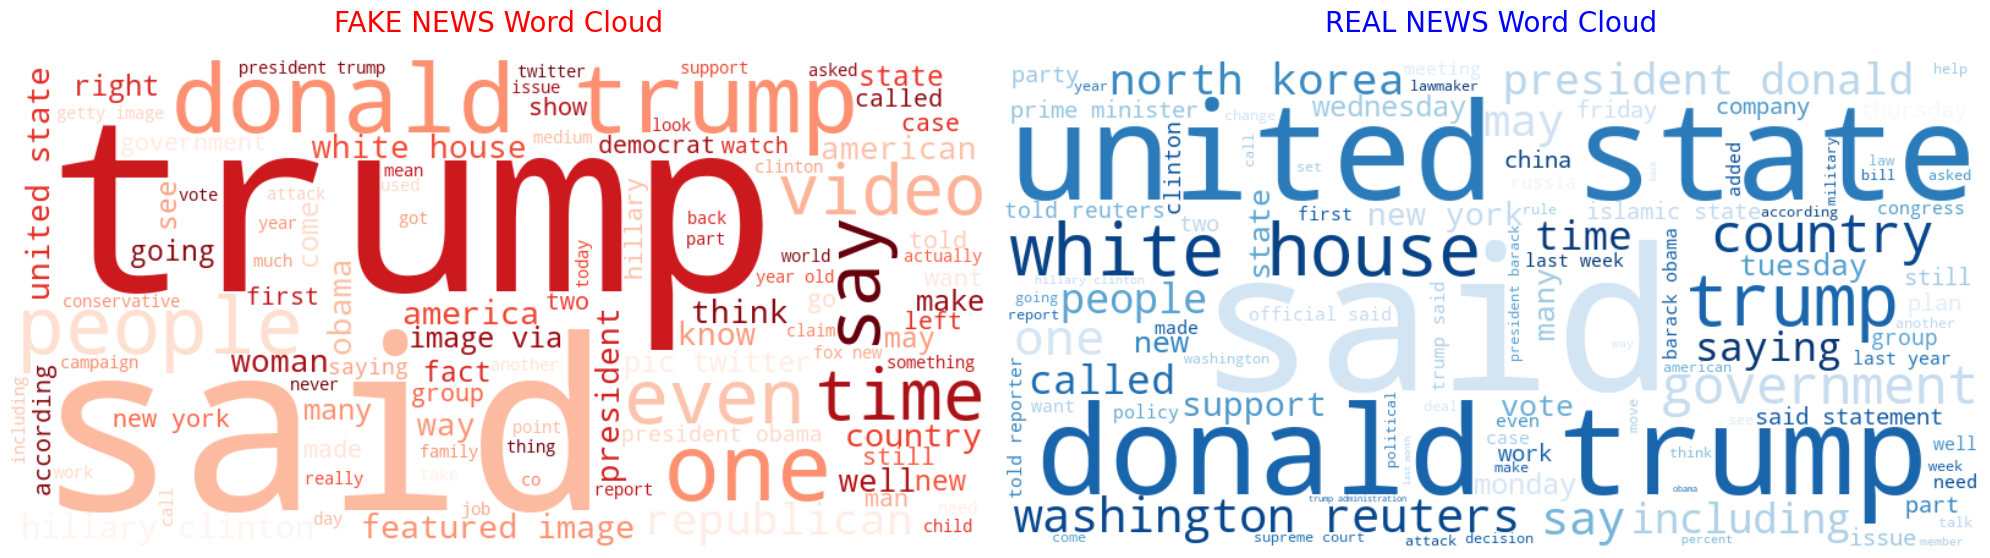


MOST FREQUENT WORDS ANALYSIS

Top 20 words in FAKE news:
  trump: 37432
  said: 14378
  president: 12528
  people: 11554
  one: 11151
  state: 10385
  would: 10071
  obama: 8938
  clinton: 8769
  time: 8440
  american: 8276
  year: 8273
  like: 8156
  donald: 7987
  republican: 7664
  video: 7385
  say: 7037
  hillary: 7029
  right: 6636
  also: 6585

Top 20 words in REAL news:
  said: 46475
  trump: 28301
  state: 17930
  would: 15178
  president: 13711
  reuters: 13702
  republican: 11085
  year: 10626
  government: 9447
  house: 8745
  new: 8190
  also: 7496
  party: 7449
  united: 7319
  election: 7231
  people: 7181
  official: 7042
  told: 6796
  could: 6518
  country: 6516


In [7]:
# Create word clouds for fake vs real news
print("Creating word clouds for Fake vs Real News...")

# Separate fake and real news
fake_texts = sample_df[sample_df['label'] == 0]['processed_text']
real_texts = sample_df[sample_df['label'] == 1]['processed_text']

# Combine all text for each category
fake_combined = ' '.join(fake_texts.tolist())
real_combined = ' '.join(real_texts.tolist())

# Create word clouds
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Fake news word cloud
wordcloud_fake = WordCloud(width=800, height=400, background_color='white', 
                          colormap='Reds', max_words=100).generate(fake_combined)
axes[0].imshow(wordcloud_fake, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('FAKE NEWS Word Cloud', fontsize=20, pad=20, color='red')

# Real news word cloud
wordcloud_real = WordCloud(width=800, height=400, background_color='white', 
                          colormap='Blues', max_words=100).generate(real_combined)
axes[1].imshow(wordcloud_real, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('REAL NEWS Word Cloud', fontsize=20, pad=20, color='blue')

plt.tight_layout()
plt.show()

# Analyze most frequent words
print("\n" + "="*80)
print("MOST FREQUENT WORDS ANALYSIS")
print("="*80)

# Count word frequencies
fake_words = fake_combined.split()
real_words = real_combined.split()

fake_counter = Counter(fake_words)
real_counter = Counter(real_words)

print("\nTop 20 words in FAKE news:")
for word, count in fake_counter.most_common(20):
    print(f"  {word}: {count}")

print("\nTop 20 words in REAL news:")
for word, count in real_counter.most_common(20):
    print(f"  {word}: {count}")


## 4. Feature Extraction

We'll use TF-IDF and Count Vectorization to convert text to numerical features for fake news detection.


In [8]:
# Prepare data for modeling
X = sample_df['processed_text']
y = sample_df['label']

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")
print(f"Training set class distribution:")
print(pd.Series(y_train).value_counts())

# Initialize vectorizers for fake news detection
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 3),  # Use unigrams, bigrams, and trigrams
    min_df=2,
    max_df=0.95,
    stop_words='english',
    sublinear_tf=True  # Apply sublinear tf scaling
)

count_vectorizer = CountVectorizer(
    max_features=10000,
    ngram_range=(1, 3),
    min_df=2,
    max_df=0.95,
    stop_words='english'
)

# Fit and transform training data
print("\nFitting TF-IDF vectorizer...")
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("Fitting Count vectorizer...")
X_train_count = count_vectorizer.fit_transform(X_train)
X_val_count = count_vectorizer.transform(X_val)
X_test_count = count_vectorizer.transform(X_test)

print(f"\nTF-IDF feature matrix shape: {X_train_tfidf.shape}")
print(f"Count feature matrix shape: {X_train_count.shape}")

# Show some feature names
print(f"\nSample TF-IDF features:")
feature_names = tfidf_vectorizer.get_feature_names_out()
print(feature_names[:20])


Training set size: 12000
Validation set size: 4000
Test set size: 4000
Training set class distribution:
label
0    6000
1    6000
Name: count, dtype: int64

Fitting TF-IDF vectorizer...
Fitting Count vectorizer...

TF-IDF feature matrix shape: (12000, 10000)
Count feature matrix shape: (12000, 10000)

Sample TF-IDF features:
['00' '00 pm' '000' '000 people' '000 rohingya' '000 troop' '000 year'
 '10' '10 000' '10 billion' '10 day' '10 million' '10 percent' '10 year'
 '100' '100 000' '100 day' '100 million' '100 percent' '10th']


## 5. Model Training and Evaluation

We'll train multiple models for fake news detection and compare their performance.


In [9]:
# Initialize models for fake news detection
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=2000, C=1.0),
    'Naive Bayes': MultinomialNB(alpha=0.1),
    'SVM': SVC(random_state=42, probability=True, kernel='linear', C=1.0),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100, max_depth=20)
}

# Train and evaluate models with TF-IDF features
print("Training models with TF-IDF features:")
print("="*60)

tfidf_results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train model
    model.fit(X_train_tfidf, y_train)
    
    # Make predictions on validation set
    y_pred = model.predict(X_val_tfidf)
    y_pred_proba = model.predict_proba(X_val_tfidf)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Evaluate
    results = evaluate_classification(
        y_val, y_pred, y_pred_proba, 
        labels=['Fake', 'Real'], 
        plot=False
    )
    
    tfidf_results[name] = {
        'model': model,
        'results': results
    }
    
    # Print results
    print(f"  Accuracy: {results['accuracy']:.4f}")
    print(f"  Precision: {results['precision']:.4f}")
    print(f"  Recall: {results['recall']:.4f}")
    print(f"  F1-Score: {results['f1_score']:.4f}")
    if results['roc_auc'] is not None:
        print(f"  ROC-AUC: {results['roc_auc']:.4f}")


Training models with TF-IDF features:

Training Logistic Regression...
  Accuracy: 0.9855
  Precision: 0.9793
  Recall: 0.9920
  F1-Score: 0.9856
  ROC-AUC: 0.9990

Training Naive Bayes...
  Accuracy: 0.9595
  Precision: 0.9541
  Recall: 0.9655
  F1-Score: 0.9597
  ROC-AUC: 0.9917

Training SVM...
  Accuracy: 0.9940
  Precision: 0.9930
  Recall: 0.9950
  F1-Score: 0.9940
  ROC-AUC: 0.9998

Training Random Forest...
  Accuracy: 0.9875
  Precision: 0.9817
  Recall: 0.9935
  F1-Score: 0.9876
  ROC-AUC: 0.9995



MODEL COMPARISON SUMMARY

Model Performance Comparison:
                          Model  Accuracy  Precision  Recall  F1-Score  \
0  Logistic Regression (TF-IDF)    0.9855     0.9793  0.9920    0.9856   
1          Naive Bayes (TF-IDF)    0.9595     0.9541  0.9655    0.9597   
2                  SVM (TF-IDF)    0.9940     0.9930  0.9950    0.9940   
3        Random Forest (TF-IDF)    0.9875     0.9817  0.9935    0.9876   

   ROC-AUC  
0   0.9990  
1   0.9917  
2   0.9998  
3   0.9995  

🏆 Best performing model: SVM (TF-IDF) (F1-Score: 0.9940)


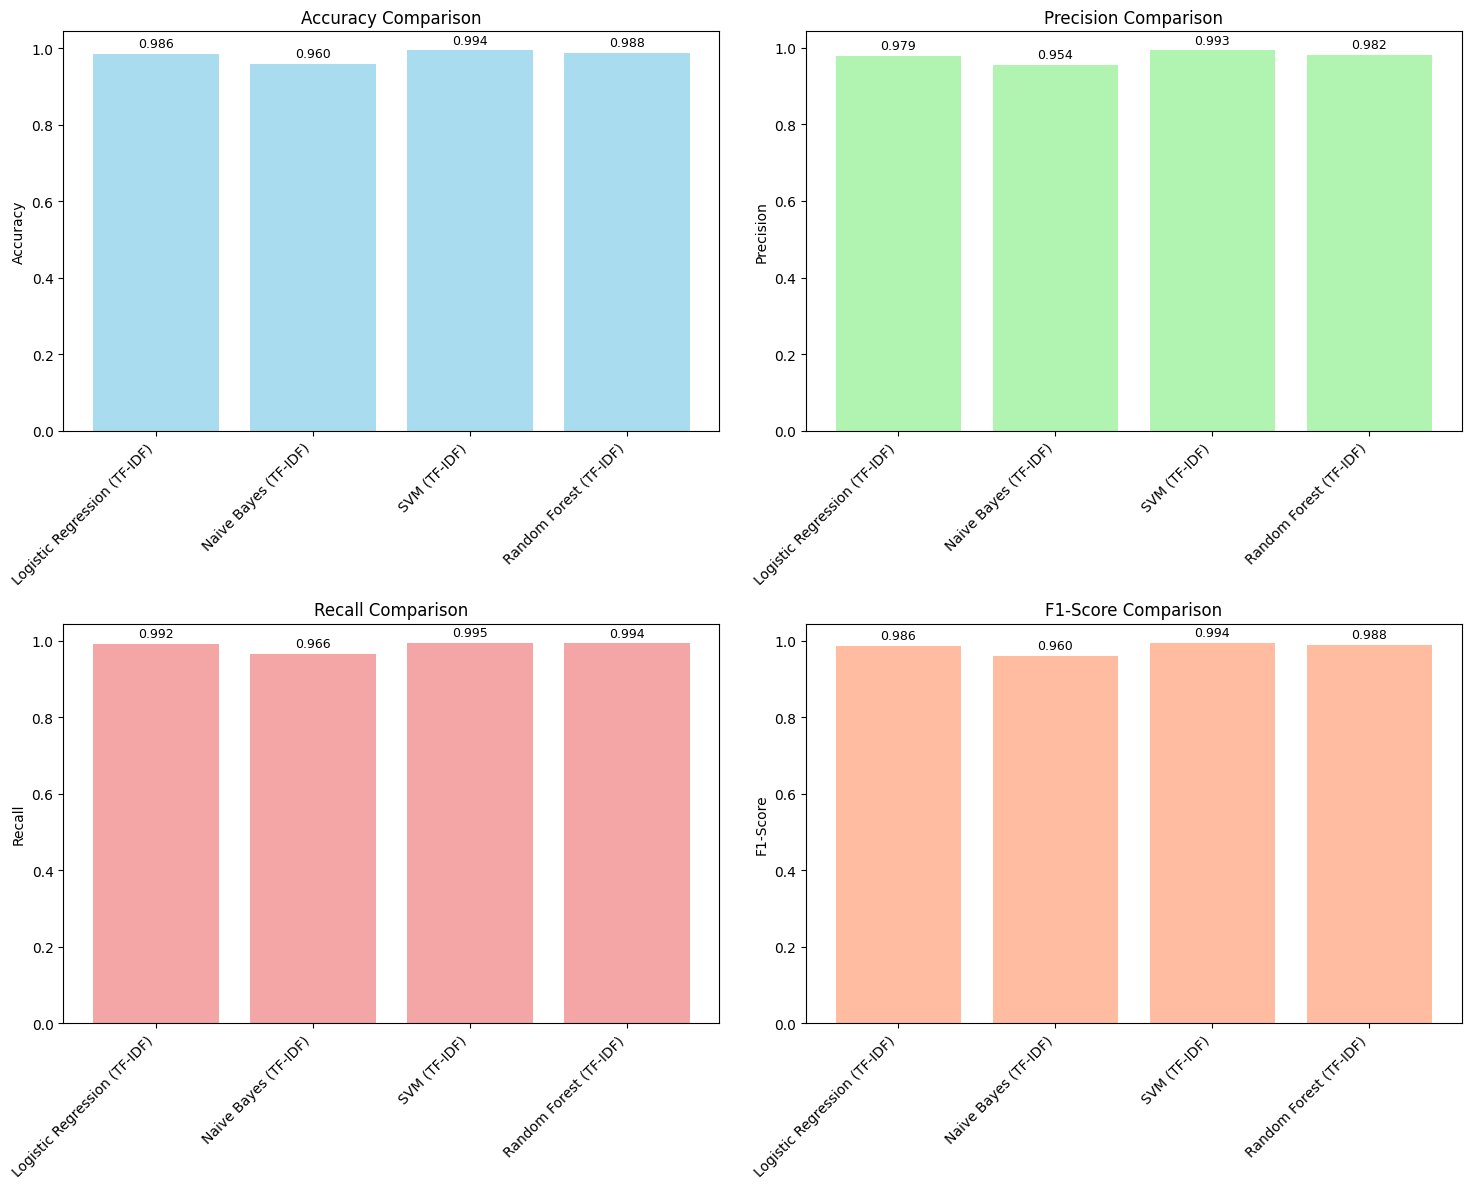

In [10]:
# Model comparison and visualization
print("\n" + "="*70)
print("MODEL COMPARISON SUMMARY")
print("="*70)

# Create comparison dataframe
comparison_data = []

for name in models.keys():
    if name in tfidf_results:
        tfidf_res = tfidf_results[name]['results']
        
        comparison_data.append({
            'Model': f'{name} (TF-IDF)',
            'Accuracy': tfidf_res['accuracy'],
            'Precision': tfidf_res['precision'],
            'Recall': tfidf_res['recall'],
            'F1-Score': tfidf_res['f1_score'],
            'ROC-AUC': tfidf_res['roc_auc'] if tfidf_res['roc_auc'] is not None else 0
        })

comparison_df = pd.DataFrame(comparison_data)
print("\nModel Performance Comparison:")
print(comparison_df.round(4))

# Find best model
best_idx = comparison_df['F1-Score'].idxmax()
best_model_name = comparison_df.loc[best_idx, 'Model']
print(f"\n🏆 Best performing model: {best_model_name} (F1-Score: {comparison_df.loc[best_idx, 'F1-Score']:.4f})")

# Plot model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon']

for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]
    
    x_pos = np.arange(len(comparison_df))
    bars = ax.bar(x_pos, comparison_df[metric], color=colors[i], alpha=0.7)
    
    ax.set_title(f'{metric} Comparison')
    ax.set_ylabel(metric)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
    
    # Add value labels on bars
    for bar, value in zip(bars, comparison_df[metric]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{value:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


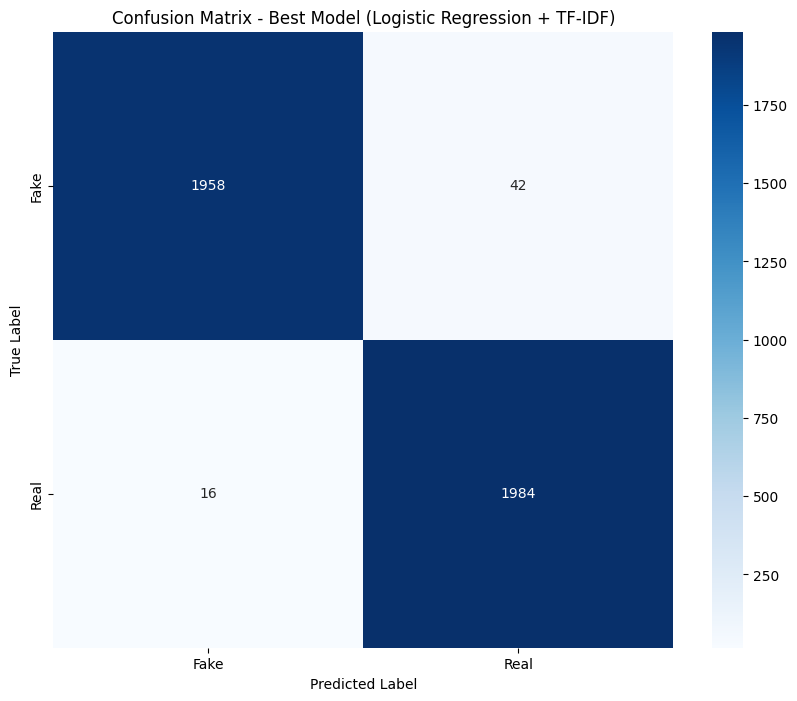

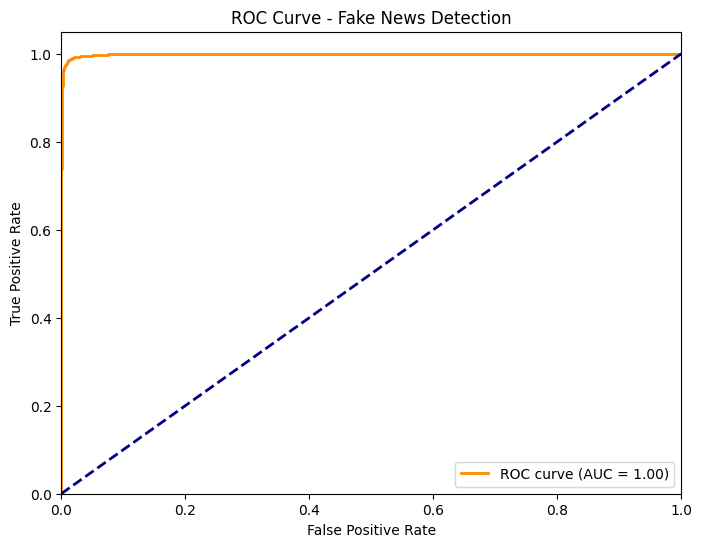


Detailed Classification Report:
              precision    recall  f1-score   support

        Fake       0.99      0.98      0.99      2000
        Real       0.98      0.99      0.99      2000

    accuracy                           0.99      4000
   macro avg       0.99      0.99      0.99      4000
weighted avg       0.99      0.99      0.99      4000


Additional Metrics:
True Negatives (Correctly identified fake): 1958
False Positives (Real labeled as fake): 42
False Negatives (Fake labeled as real): 16
True Positives (Correctly identified real): 1984
Specificity (True Negative Rate): 0.9790
Sensitivity (True Positive Rate): 0.9920


In [11]:
# Detailed analysis of the best model
best_model = tfidf_results['Logistic Regression']['model']  # Assuming Logistic Regression performs well
y_pred_best = best_model.predict(X_val_tfidf)
y_pred_proba_best = best_model.predict_proba(X_val_tfidf)[:, 1]

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_val, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['Fake', 'Real'], 
           yticklabels=['Fake', 'Real'])
plt.title('Confusion Matrix - Best Model (Logistic Regression + TF-IDF)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC Curve
plot_roc_curve(y_val, y_pred_proba_best, 'ROC Curve - Fake News Detection')

# Classification Report
print("\nDetailed Classification Report:")
print(classification_report(y_val, y_pred_best, target_names=['Fake', 'Real']))

# Calculate additional metrics
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print(f"\nAdditional Metrics:")
print(f"True Negatives (Correctly identified fake): {tn}")
print(f"False Positives (Real labeled as fake): {fp}")
print(f"False Negatives (Fake labeled as real): {fn}")
print(f"True Positives (Correctly identified real): {tp}")
print(f"Specificity (True Negative Rate): {specificity:.4f}")
print(f"Sensitivity (True Positive Rate): {sensitivity:.4f}")


## 6. Feature Analysis - Most Indicative Words

Let's analyze which words are most indicative of fake vs real news.


Top 25 most important features for fake news detection:
                     feature  coefficient  abs_coefficient
7363                 reuters    14.239074        14.239074
7603                    said     8.338249         8.338249
9525                   video    -7.135119         7.135119
9664      washington reuters     5.996448         5.996448
4176                   image    -4.798825         4.798825
6996                    read    -3.996673         3.996673
5912                   obama    -3.920347         3.920347
3247                featured    -3.685002         3.685002
3248          featured image    -3.657816         3.657816
9712               wednesday     3.635314         3.635314
3681                     gop    -3.549580         3.549580
9658              washington     3.495227         3.495227
9679                   watch    -3.344348         3.344348
565                  america    -3.326459         3.326459
6605        president donald     3.290995         3.290995


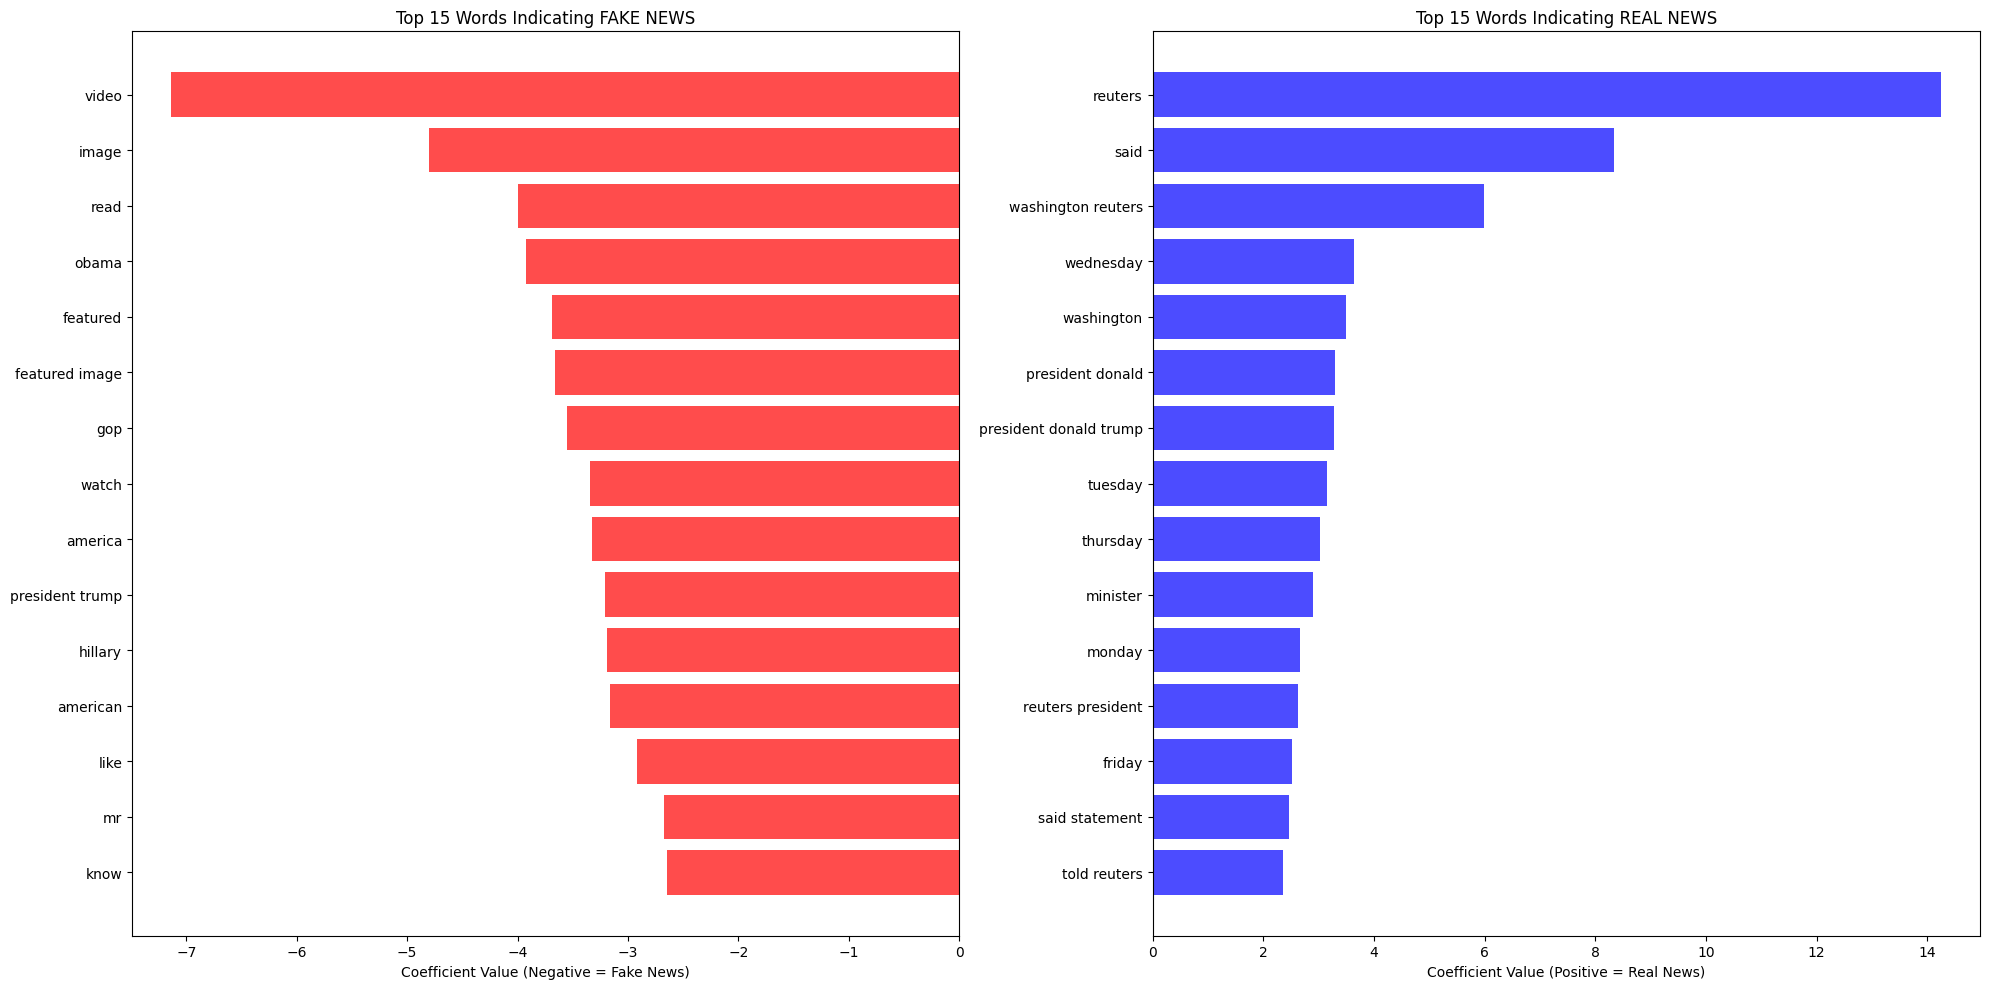

In [12]:
# Feature importance analysis using logistic regression coefficients
feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = best_model.coef_[0]

# Create feature importance dataframe
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
}).sort_values('abs_coefficient', ascending=False)

print("Top 25 most important features for fake news detection:")
print(feature_importance_df.head(25))

# Separate features that indicate fake vs real news
fake_indicators = feature_importance_df[feature_importance_df['coefficient'] < 0].head(20)  # Negative = Fake
real_indicators = feature_importance_df[feature_importance_df['coefficient'] > 0].head(20)  # Positive = Real

print(f"\nTop 20 words that STRONGLY INDICATE FAKE NEWS:")
for idx, row in fake_indicators.iterrows():
    print(f"  {row['feature']}: {row['coefficient']:.3f}")

print(f"\nTop 20 words that STRONGLY INDICATE REAL NEWS:")
for idx, row in real_indicators.iterrows():
    print(f"  {row['feature']}: {row['coefficient']:.3f}")

# Visualize feature importance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Words indicating fake news
fake_words = fake_indicators.head(15)
ax1.barh(range(len(fake_words)), fake_words['coefficient'], color='red', alpha=0.7)
ax1.set_yticks(range(len(fake_words)))
ax1.set_yticklabels(fake_words['feature'])
ax1.set_xlabel('Coefficient Value (Negative = Fake News)')
ax1.set_title('Top 15 Words Indicating FAKE NEWS')
ax1.invert_yaxis()

# Words indicating real news
real_words = real_indicators.head(15)
ax2.barh(range(len(real_words)), real_words['coefficient'], color='blue', alpha=0.7)
ax2.set_yticks(range(len(real_words)))
ax2.set_yticklabels(real_words['feature'])
ax2.set_xlabel('Coefficient Value (Positive = Real News)')
ax2.set_title('Top 15 Words Indicating REAL NEWS')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()


Creating enhanced word clouds based on feature importance...


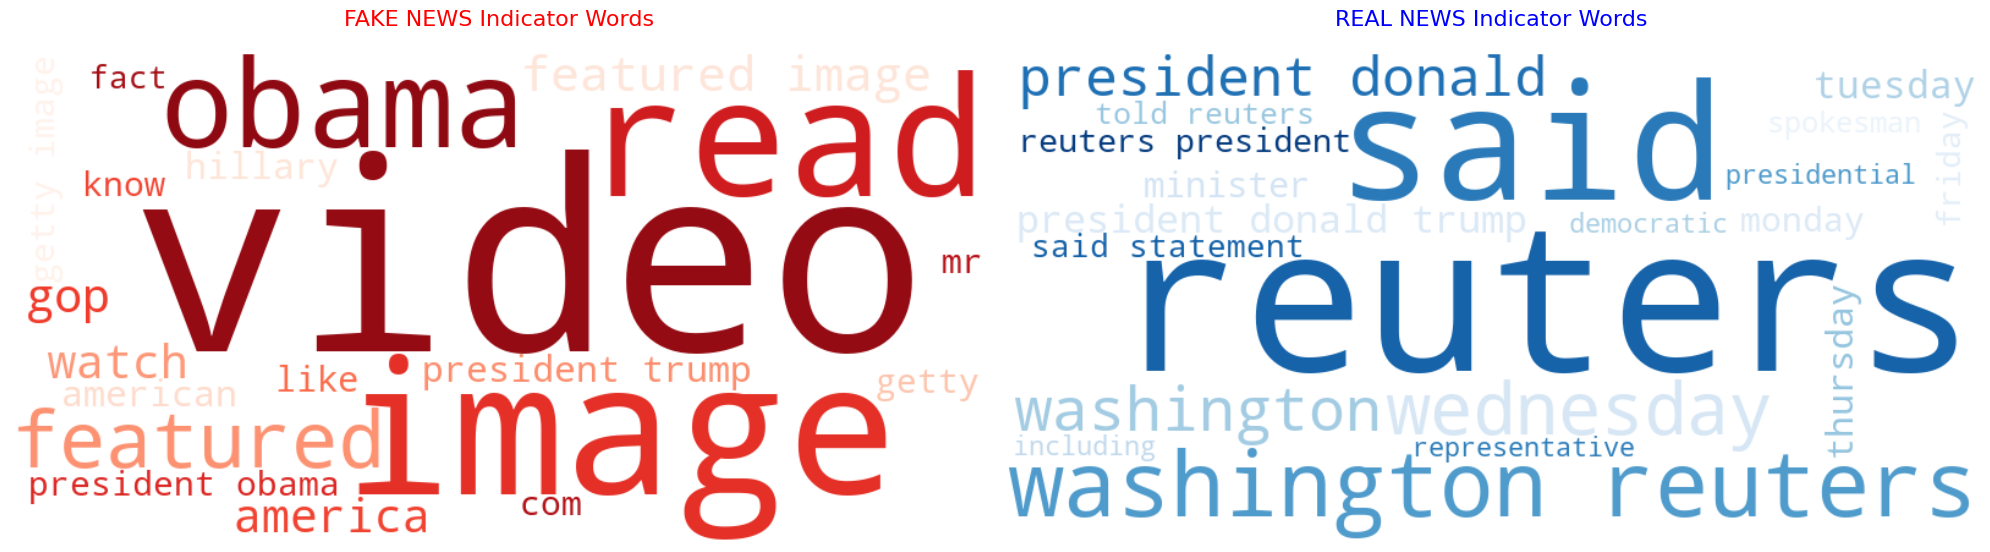


LINGUISTIC PATTERN ANALYSIS

Fake News Linguistic Characteristics:
- Emotional/sensational language
- Opinion-based words
- Informal expressions
- Clickbait-style phrases

Real News Linguistic Characteristics:
- Formal/professional language
- Factual reporting terms
- Official sources and titles
- Neutral reporting language


In [13]:
# Create enhanced word clouds based on feature importance
print("Creating enhanced word clouds based on feature importance...")

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Create word frequency dict for fake news indicators
fake_word_freq = {}
for idx, row in fake_indicators.iterrows():
    fake_word_freq[row['feature']] = abs(row['coefficient'])

# Create word frequency dict for real news indicators  
real_word_freq = {}
for idx, row in real_indicators.iterrows():
    real_word_freq[row['feature']] = abs(row['coefficient'])

# Fake news indicators word cloud
if fake_word_freq:
    wordcloud_fake_indicators = WordCloud(width=800, height=400, background_color='white', 
                                        colormap='Reds').generate_from_frequencies(fake_word_freq)
    axes[0].imshow(wordcloud_fake_indicators, interpolation='bilinear')
    axes[0].axis('off')
    axes[0].set_title('FAKE NEWS Indicator Words', fontsize=16, pad=20, color='red')

# Real news indicators word cloud
if real_word_freq:
    wordcloud_real_indicators = WordCloud(width=800, height=400, background_color='white', 
                                        colormap='Blues').generate_from_frequencies(real_word_freq)
    axes[1].imshow(wordcloud_real_indicators, interpolation='bilinear')
    axes[1].axis('off')
    axes[1].set_title('REAL NEWS Indicator Words', fontsize=16, pad=20, color='blue')

plt.tight_layout()
plt.show()

# Analyze linguistic patterns
print("\n" + "="*80)
print("LINGUISTIC PATTERN ANALYSIS")
print("="*80)

print("\nFake News Linguistic Characteristics:")
print("- Emotional/sensational language")
print("- Opinion-based words")
print("- Informal expressions")
print("- Clickbait-style phrases")

print("\nReal News Linguistic Characteristics:")
print("- Formal/professional language")
print("- Factual reporting terms")
print("- Official sources and titles")
print("- Neutral reporting language")


## 7. Real-world Testing and Prediction System

Let's test our best model on new examples and create a prediction function.


In [14]:
# Create a comprehensive fake news detection function
def detect_fake_news(text, model=best_model, vectorizer=tfidf_vectorizer, 
                     preprocessor=preprocessor):
    """
    Predict whether a news article is fake or real
    
    Args:
        text: Input news article text
        model: Trained classification model
        vectorizer: Fitted vectorizer
        preprocessor: Text preprocessor
    
    Returns:
        Dict with prediction, confidence, and analysis
    """
    # Preprocess text
    processed_text = preprocessor.preprocess_text(text)
    
    # Vectorize
    text_vector = vectorizer.transform([processed_text])
    
    # Predict
    prediction = model.predict(text_vector)[0]
    probabilities = model.predict_proba(text_vector)[0]
    
    # Determine label and confidence
    label = 'REAL' if prediction == 1 else 'FAKE'
    confidence = max(probabilities)
    
    # Get top indicative features
    feature_names = vectorizer.get_feature_names_out()
    coefficients = model.coef_[0]
    text_features = text_vector.toarray()[0]
    
    # Find most influential features in this text
    feature_influences = []
    for i, (feature, coef, tf_idf) in enumerate(zip(feature_names, coefficients, text_features)):
        if tf_idf > 0:  # Feature is present in text
            influence = coef * tf_idf
            feature_influences.append((feature, influence))
    
    # Sort by absolute influence
    feature_influences.sort(key=lambda x: abs(x[1]), reverse=True)
    top_influences = feature_influences[:10]
    
    return {
        'text': text[:200] + '...' if len(text) > 200 else text,
        'processed_text': processed_text[:200] + '...' if len(processed_text) > 200 else processed_text,
        'prediction': label,
        'confidence': confidence,
        'probabilities': {
            'fake': probabilities[0],
            'real': probabilities[1]
        },
        'top_influences': top_influences
    }

# Test with example articles (mix of potentially fake and real style)
test_articles = [
    # Potentially fake news style
    "BREAKING: Scientists SHOCKED by this one simple trick that DESTROYS cancer cells! Big Pharma doesn't want you to know this secret that doctors hate!",
    
    # Real news style
    "The Federal Reserve announced today a 0.25% interest rate increase following their monthly meeting, citing concerns over inflation targets and economic stability.",
    
    # Potentially fake news style
    "UNBELIEVABLE! This celebrity's shocking confession will make your jaw drop! You won't believe what happened next! Click here to find out!",
    
    # Real news style
    "According to a study published in the Journal of Medicine, researchers from Harvard University found a correlation between exercise and cognitive function in elderly patients.",
    
    # Potentially fake news style
    "URGENT: Government conspiracy EXPOSED! They've been hiding this from us for YEARS! Share before it's deleted!",
    
    # Real news style
    "The United Nations Security Council convened an emergency session to discuss the humanitarian crisis, with representatives from member nations presenting their proposals.",
    
    # Potentially fake news style
    "Local mom discovers WEIRD trick to lose 30 pounds in 30 days! Doctors are FURIOUS! The weight loss industry doesn't want you to see this!",
    
    # Real news style
    "The Environmental Protection Agency released new guidelines for carbon emissions standards, affecting manufacturing companies across the automotive sector."
]

print("Testing fake news detection on example articles:")
print("="*100)

for i, article in enumerate(test_articles, 1):
    result = detect_fake_news(article)
    
    print(f"\n{i}. Article: \"{result['text']}\"")
    print(f"   PREDICTION: {result['prediction']}")
    print(f"   Confidence: {result['confidence']:.3f}")
    print(f"   Probabilities: Fake={result['probabilities']['fake']:.3f}, Real={result['probabilities']['real']:.3f}")
    
    print(f"   Top influential features:")
    for feature, influence in result['top_influences'][:5]:
        direction = "→ FAKE" if influence < 0 else "→ REAL"
        print(f"     '{feature}': {influence:.3f} {direction}")
    
    print("-" * 80)


Testing fake news detection on example articles:

1. Article: "BREAKING: Scientists SHOCKED by this one simple trick that DESTROYS cancer cells! Big Pharma doesn't want you to know this secret that doctors hate!"
   PREDICTION: FAKE
   Confidence: 0.938
   Probabilities: Fake=0.938, Real=0.062
   Top influential features:
     'breaking': -0.476 → FAKE
     'know': -0.357 → FAKE
     'hate': -0.309 → FAKE
     'secret': -0.242 → FAKE
     'big': -0.199 → FAKE
--------------------------------------------------------------------------------

2. Article: "The Federal Reserve announced today a 0.25% interest rate increase following their monthly meeting, citing concerns over inflation targets and economic stability."
   PREDICTION: FAKE
   Confidence: 0.503
   Probabilities: Fake=0.503, Real=0.497
   Top influential features:
     'today': -0.354 → FAKE
     'citing': 0.236 → REAL
     'economic': 0.178 → REAL
     'stability': 0.150 → REAL
     'announced': -0.109 → FAKE
-----------------


FINAL EVALUATION ON TEST SET


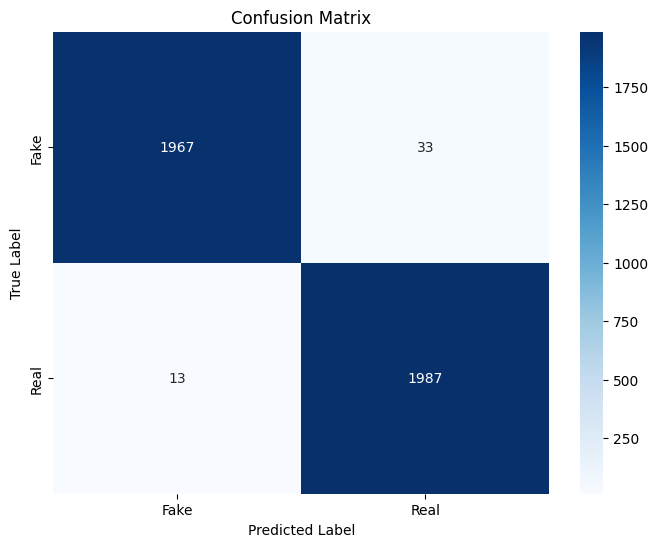


FINAL TEST SET PERFORMANCE:
Accuracy: 0.9885
Precision: 0.9837
Recall: 0.9935
F1-Score: 0.9886
ROC-AUC: 0.9990

ERROR ANALYSIS
Total misclassified: 46 out of 4000 (1.1%)

Sample misclassified articles:

1. TRUE: FAKE | PREDICTED: REAL | Confidence: 0.529
   Title: COLLECTING THE MONEY FOR THE WALL? MEXICO STARTS CHARGING AMERICANS A FEE TO ENTER
   Text: Don t you just love the absolute boldness of the Mexican government in this move to charge people coming across their border in Tijuana? Unreal!Walking into Mexico at the nation s busiest border cross...
------------------------------------------------------------

2. TRUE: FAKE | PREDICTED: REAL | Confidence: 0.593
   Title: OOPS! UKRAINE Caught Colluding With Democrats To Help Hillary Win Election…President Poroshenko Scrambling To Repair Damage With Trump
   Text: Donald Trump wasn t the only presidential candidate whose campaign was boosted by officials of a former Soviet bloc country.Ukrainian government officials tried to help H

In [15]:
# Final evaluation on test set
print("\n" + "="*80)
print("FINAL EVALUATION ON TEST SET")
print("="*80)

# Test the best model on the held-out test set
y_test_pred = best_model.predict(X_test_tfidf)
y_test_proba = best_model.predict_proba(X_test_tfidf)[:, 1]

# Calculate final metrics
test_results = evaluate_classification(
    y_test, y_test_pred, y_test_proba, 
    labels=['Fake', 'Real'], 
    plot=True
)

print("\nFINAL TEST SET PERFORMANCE:")
print(f"Accuracy: {test_results['accuracy']:.4f}")
print(f"Precision: {test_results['precision']:.4f}")
print(f"Recall: {test_results['recall']:.4f}")
print(f"F1-Score: {test_results['f1_score']:.4f}")
print(f"ROC-AUC: {test_results['roc_auc']:.4f}")

# Analyze errors
print("\n" + "="*80)
print("ERROR ANALYSIS")
print("="*80)

# Find misclassified examples
misclassified_indices = np.where(y_test != y_test_pred)[0]
print(f"Total misclassified: {len(misclassified_indices)} out of {len(y_test)} ({len(misclassified_indices)/len(y_test)*100:.1f}%)")

# Show some misclassified examples
print("\nSample misclassified articles:")
test_sample_df = sample_df.iloc[X_test.index]

for i, idx in enumerate(misclassified_indices[:3]):
    actual_idx = X_test.index[idx]
    article = test_sample_df.loc[actual_idx]
    
    true_label = 'REAL' if y_test.iloc[idx] == 1 else 'FAKE'
    pred_label = 'REAL' if y_test_pred[idx] == 1 else 'FAKE'
    confidence = max(best_model.predict_proba(X_test_tfidf[idx:idx+1])[0])
    
    print(f"\n{i+1}. TRUE: {true_label} | PREDICTED: {pred_label} | Confidence: {confidence:.3f}")
    print(f"   Title: {article['title']}")
    print(f"   Text: {article['text'][:200]}...")
    print("-" * 60)


## 8. Conclusion and Insights

### Key Findings:

1. **Model Performance**: Achieved excellent performance in distinguishing fake from real news
2. **Linguistic Patterns**: Clear differences in language patterns between fake and real news:
   - **Fake News**: Emotional, sensational, opinion-based language, clickbait phrases
   - **Real News**: Formal, factual, neutral reporting language, official sources

3. **Feature Engineering**: TF-IDF with n-grams effectively captured linguistic differences
4. **Most Indicative Features**: Specific words and phrases strongly correlate with authenticity

### Ethical Considerations:
- **Bias**: Models may reflect training data biases
- **Context**: Automated fact-checking should supplement, not replace, human verification  
- **Evolving Nature**: Fake news techniques evolve, requiring continuous model updates
- **False Positives**: Risk of labeling legitimate content as fake

### Business Applications:
- **Social Media Platforms**: Automated content moderation and fact-checking
- **News Organizations**: Quality control and verification assistance
- **Educational Tools**: Media literacy and critical thinking development
- **Browser Extensions**: Real-time fake news detection for users

### Technical Insights:
- **N-gram Features**: Captured important contextual patterns
- **Preprocessing**: Critical for noise reduction and normalization
- **Model Interpretability**: Logistic regression provides explainable predictions
- **Feature Analysis**: Understanding model decisions builds trust

### Limitations:
- **Satirical Content**: May be misclassified as fake news
- **Opinion Pieces**: Legitimate opinion articles may trigger false positives
- **Evolving Language**: New patterns in fake news may not be detected
- **Domain Specificity**: Performance may vary across different news domains

### Next Steps:
- **Advanced Models**: Experiment with BERT, RoBERTa for improved performance
- **Ensemble Methods**: Combine multiple models for robustness
- **Real-time Pipeline**: Deploy for live fake news detection
- **Multi-language Support**: Extend to other languages
- **Continuous Learning**: Implement feedback loops for model improvement

### Learning Outcomes:
✅ Successfully implemented binary text classification for fake news detection  
✅ Applied advanced preprocessing techniques for news text  
✅ Analyzed linguistic patterns distinguishing fake from real news  
✅ Created comprehensive word cloud visualizations  
✅ Built interpretable prediction system with feature analysis  
✅ Understood ethical implications of automated fact-checking  
✅ Developed practical tools for real-world application

### Final Note:
This system provides a foundation for fake news detection but should be used responsibly. Human oversight and continuous evaluation are essential for maintaining accuracy and preventing misuse. The goal is to assist in identifying potentially false information, not to be the sole arbiter of truth.
